In [113]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
#import mpld3
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import filter_output_reader as freader
from importlib import reload

import scipy.stats as stats

%matplotlib inline

In [114]:
example_datafile = 'example_data.txt'
filter_config = '../cpp/tests/assembly/connectivity.txt'
output_data = '../cpp/test_output.txt'

fed = open(example_datafile, 'r')
fc = open(filter_config, 'r')

In [138]:
reload(freader)
dns_data = freader.read_dns_data(example_datafile)
nodes, conn = freader.read_filter_configuration(filter_config)
filter_result = freader.read_output_data(output_data)

Reading data from:   ../python/example_data.txt
Filter defined in:   ./tests/assembly/connectivity.txt


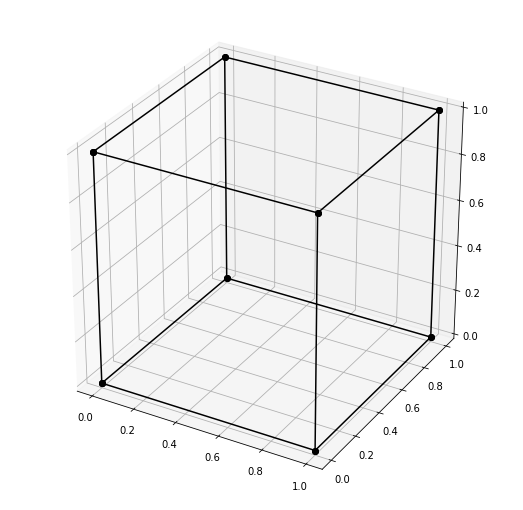

In [139]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')
freader.plot_hex(10, nodes, conn, ax)

[3.51325, -0.279734, 2.44028]
[3.86314, 0.383795, 3.11076]
[3.73169, 0.345965, 3.40802]
[3.38307, -0.317347, 2.73776]
[3.92459, -0.470034, 2.34113]
[4.27321, 0.193277, 3.01139]
[4.14302, 0.155665, 3.30887]
[3.79313, -0.507864, 2.63839]


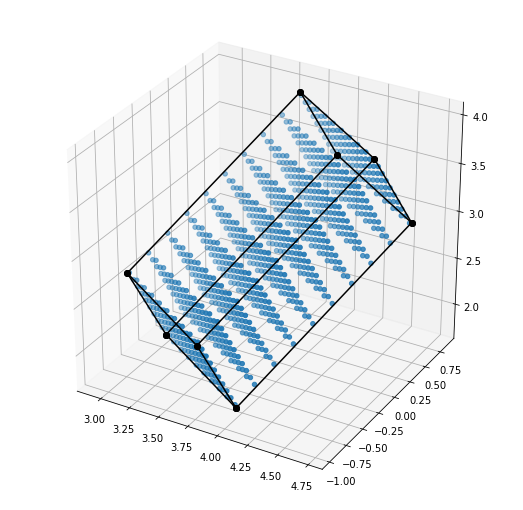

In [140]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

eid = 10
t = 1
ax.scatter(*zip(*dns_data[t]))
freader.plot_hex_filter(eid, t, filter_result, ax)
freader.plot_filter_cgs(eid, t, filter_result, ax)


In [131]:
filter_result[t][eid]

MicromorphicFilterData:
 nodes:
   +3.1977 -0.4989 +1.9933
   +3.8994 +0.8491 +3.3545
   +3.6260 +0.7649 +3.9682
   +2.9243 -0.5832 +2.6070
   +4.0303 -0.8889 +1.7809
   +4.7320 +0.4591 +3.1421
   +4.4586 +0.3748 +3.7558
   +3.7568 -0.9732 +2.3946
 dof values:
   +3.1977 -0.4989 +1.9933 -0.3076 -1.1183 -1.2504 -0.4023 +0.8586
   +2.8994 +0.8491 +3.3545 -0.3076 -1.1183 -1.2504 -0.4023 +0.8586
   +2.6260 -0.2351 +3.9682 -0.3076 -1.1183 -1.2504 -0.4023 +0.8586
   +2.9243 -1.5832 +2.6070 -0.3076 -1.1183 -1.2504 -0.4023 +0.8586
   +4.0303 -0.8889 +0.7809 -0.3076 -1.1183 -1.2504 -0.4023 +0.8586
   +3.7320 +0.4591 +2.1421 -0.3076 -1.1183 -1.2504 -0.4023 +0.8586
   +3.4586 -0.6252 +2.7558 -0.3076 -1.1183 -1.2504 -0.4023 +0.8586
   +3.7568 -1.9732 +1.3946 -0.3076 -1.1183 -1.2504 -0.4023 +0.8586
 Gauss Point Information
  Volumes:   0.1228 0.1201 0.1192 0.1206 0.1192 0.1206 0.1228 0.1201
  Densities: 2700.0000 2700.0000 2700.0000 2700.0000 2700.0000 2700.0000 2700.0000 2700.0000
  Local Mass Cen